MODEL BUILDING

* Total Data Rows: 366days * 48 intervals * 50 clusters = 878400

* AIM: To forecast demand for a given latitude-longitude`

* Metric: RMSE, how close we are able to predict ride demand to true value`

NEXT STEPS .......
* We now have clean, good ride requests data.
* Cluster of Latitude-Longitude is done, we have around 50 pickup_clusters.
* We have grouped ride request day in 30mins interval. 

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from math import sqrt, ceil, floor
import matplotlib.pyplot as plt
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from joblib import dump, load
%matplotlib inline

In [2]:
df = pd.read_csv('../data/data_checkpoint/preped_data.csv', compression = 'gzip')

In [3]:
df.info

<bound method DataFrame.info of                          ts  pickup_cluster  request_count  mins  hour  day  \
0       2020-03-26 00:00:00               0            0.0     0     0   26   
1       2020-03-26 00:30:00               0            0.0    30     0   26   
2       2020-03-26 01:00:00               0            0.0     0     1   26   
3       2020-03-26 01:30:00               0            0.0    30     1   26   
4       2020-03-26 02:00:00               0            0.0     0     2   26   
...                     ...             ...            ...   ...   ...  ...   
878395  2021-03-26 21:30:00              49            9.0    30    21   26   
878396  2021-03-26 22:00:00              49           11.0     0    22   26   
878397  2021-03-26 22:30:00              49            8.0    30    22   26   
878398  2021-03-26 23:00:00              49            7.0     0    23   26   
878399  2021-03-26 23:30:00              49            8.0    30    23   26   

        month  dayo

In [4]:
df.columns

Index(['ts', 'pickup_cluster', 'request_count', 'mins', 'hour', 'day', 'month',
       'dayofweek', 'quarter'],
      dtype='object')

In [5]:
df['request_count'] = pd.to_numeric(df['request_count'], downcast = 'integer')

In [6]:
df['request_count'] = pd.to_numeric(df['request_count'], downcast = 'integer')
df.ts = pd.to_datetime(df.ts)
df.head(10)

,ts,pickup_cluster,request_count,mins,hour,day,month,dayofweek,quarter
0,2020-03-26 00:00:00,0,0,0,0,26,3,3,1
1,2020-03-26 00:30:00,0,0,30,0,26,3,3,1
2,2020-03-26 01:00:00,0,0,0,1,26,3,3,1
3,2020-03-26 01:30:00,0,0,30,1,26,3,3,1
4,2020-03-26 02:00:00,0,0,0,2,26,3,3,1
5,2020-03-26 02:30:00,0,0,30,2,26,3,3,1
6,2020-03-26 03:00:00,0,0,0,3,26,3,3,1
7,2020-03-26 03:30:00,0,0,30,3,26,3,3,1
8,2020-03-26 04:00:00,0,0,0,4,26,3,3,1
9,2020-03-26 04:30:00,0,0,30,4,26,3,3,1


In [7]:
df = df[['ts','pickup_cluster','mins','hour','month','quarter','dayofweek','request_count']]

In [8]:
df

,ts,pickup_cluster,mins,hour,month,quarter,dayofweek,request_count
0,2020-03-26 00:00:00,0,0,0,3,1,3,0
1,2020-03-26 00:30:00,0,30,0,3,1,3,0
2,2020-03-26 01:00:00,0,0,1,3,1,3,0
3,2020-03-26 01:30:00,0,30,1,3,1,3,0
4,2020-03-26 02:00:00,0,0,2,3,1,3,0
...,...,...,...,...,...,...,...,...
878395,2021-03-26 21:30:00,49,30,21,3,1,4,9
878396,2021-03-26 22:00:00,49,0,22,3,1,4,11
878397,2021-03-26 22:30:00,49,30,22,3,1,4,8
878398,2021-03-26 23:00:00,49,0,23,3,1,4,7


In [9]:
# First 24days of every month in Train and last 7 days of everymonth in Test
df_train = df[df.ts.dt.day <=23]
df_test = df[df.ts.dt.day >23]

In [10]:
len(df_train)

662400

In [11]:
len(df_test)

216000

In [12]:
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1]
X_test = df_test.iloc[:,1:-1]
y_test = df_test.iloc[:,-1]

In [13]:
def metrics_calculate(regressor):
    y_pred = regressor.predict(X_test)
    rms = sqrt(mean_squared_error(y_test, y_pred))
    return rms

# Iteration: 1
Features: ['pickup_cluster','mins','hour','month','quarter','dayofweek']

In [14]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression().fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 8.354002202617076, RMSE TEST:8.141713627862325


**Overview**
- Low bias - RSME is high for both train and test test - i will work to reduce the RSME 

I will now do the following: 

* Use Ensemble Regressors: Bagging Algorithm Random forests; are bagged decision tree models that split on a subset of features on each split.
* Give Feature importance based on target variable

In [15]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300, random_state=42, n_jobs = -1, verbose=True)
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    6.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s


RMSE TRAIN: 1.972136205929341, RMSE TEST:4.761538217158011


[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.7s finished


**Observation**
The model is Overfitting as it has a higher RSME for the test set and a lower RSME for the train set comparitivly. 


In [16]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
pickup_cluster,0.527737
hour,0.221061
month,0.096613
dayofweek,0.075761
quarter,0.065274
mins,0.013554


### Moving to a Ensemble: Boosting Algorithm
+ Here: learners are learned sequentially

In [17]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=1000, max_depth=8, objective="reg:squarederror")
eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set, early_stopping_rounds=15,eval_metric="rmse")
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:9.05107
[1]	validation_0-rmse:9.00297
[2]	validation_0-rmse:8.95470
[3]	validation_0-rmse:8.90526
[4]	validation_0-rmse:8.85866
[5]	validation_0-rmse:8.80963
[6]	validation_0-rmse:8.76329
[7]	validation_0-rmse:8.71638
[8]	validation_0-rmse:8.67087
[9]	validation_0-rmse:8.62510
[10]	validation_0-rmse:8.57989
[11]	validation_0-rmse:8.53526
[12]	validation_0-rmse:8.49070
[13]	validation_0-rmse:8.44891
[14]	validation_0-rmse:8.40651
[15]	validation_0-rmse:8.36457
[16]	validation_0-rmse:8.32458
[17]	validation_0-rmse:8.28399
[18]	validation_0-rmse:8.24325
[19]	validation_0-rmse:8.20710
[20]	validation_0-rmse:8.17120
[21]	validation_0-rmse:8.13561
[22]	validation_0-rmse:8.09548
[23]	validation_0-rmse:8.06216
[24]	validation_0-rmse:8.02865
[25]	validation_0-rmse:7.99490
[26]	validation_0-rmse:7.96326
[27]	validation_0-rmse:7.92489
[28]	validation_0-rmse:7.89327
[29]	validation_0-rmse:7.86299
[30]	validation_0-rmse:7.83285
[31]	validation_0-rmse:7.80248
[32]	validation_0-

**Observation**

* Our model score is 90% 
* The XGboost better than the Random Forest Regressor, but slightly overfits with train RSME of 2.77 and a Test RSME of 4.66



In [18]:
dump(model,'../models/prediction_model_without_lag.joblib',compress=3)


['../models/prediction_model_without_lag.joblib']

#### Plot Feature Importance 

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

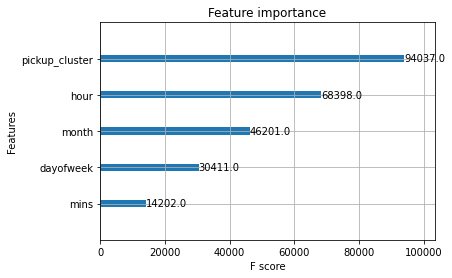

In [19]:
plot_importance(model)

## Iteration 2
Features: ['pickup_cluster', 'mins','hour', 'month', 'quarter', 'dayofweek', 'lag_1', 'lag_2', 'lag_3']

* Included: Lag Features

* If there is 30mins trend, how has ride requests been in last 1.5 hours - Hence testing with Lag Shift by 3

lag_{t} = this is simply the request_count of a region {t} mins/hours ago.

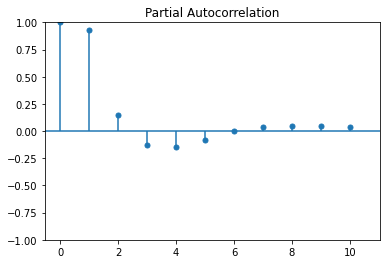

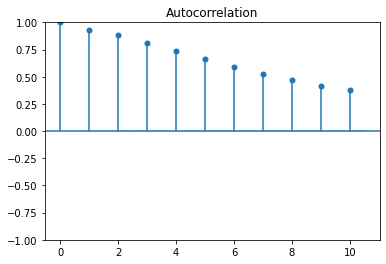

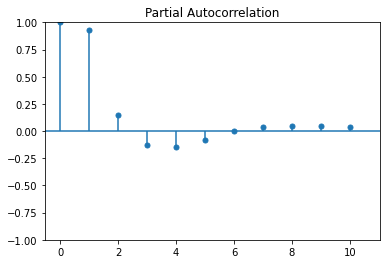

In [20]:
plot_acf(df_train['request_count'], lags=10)
plot_pacf(df_train['request_count'], lags=10)

The partial autocorrelation function shows a high correlation with the first two lag and lesser correlation with the 3rd and 4th lag. The autocorrelation function shows a slow decay, which means that the future values have a very high correlation with its past values.

+ ACF: The ACF plot is a measure of the correlation between the time series and the lagged version of itself
+ PACF: The PACF plot is a measure of the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons

In [21]:
df_test = df_test.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = pd.concat([df_train,df_test])
temp = temp.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = temp.set_index(['ts', 'pickup_cluster', 'mins','hour', 'month', 'quarter', 'dayofweek'])

temp['lag_1'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(1)
temp['lag_2'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(2)
temp['lag_3'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(3)
temp.head(15)

,,,,,,,request_count,lag_1,lag_2,lag_3
ts,pickup_cluster,mins,hour,month,quarter,dayofweek,,,,
2020-03-26 00:00:00,0,0,0,3,1,3,0,NaN,NaN,NaN
2020-03-26 00:30:00,0,30,0,3,1,3,0,0.0,NaN,NaN
2020-03-26 01:00:00,0,0,1,3,1,3,0,0.0,0.0,NaN
2020-03-26 01:30:00,0,30,1,3,1,3,0,0.0,0.0,0.0
2020-03-26 02:00:00,0,0,2,3,1,3,0,0.0,0.0,0.0
2020-03-26 02:30:00,0,30,2,3,1,3,0,0.0,0.0,0.0
2020-03-26 03:00:00,0,0,3,3,1,3,0,0.0,0.0,0.0
2020-03-26 03:30:00,0,30,3,3,1,3,0,0.0,0.0,0.0
2020-03-26 04:00:00,0,0,4,3,1,3,0,0.0,0.0,0.0


In [22]:
temp = temp.reset_index(drop = False).dropna()
temp = temp[['ts', 'pickup_cluster', 'mins','hour', 'month', 'quarter',
       'dayofweek', 'lag_1', 'lag_2', 'lag_3',
        'request_count']]

temp.head()

,ts,pickup_cluster,mins,hour,month,quarter,dayofweek,lag_1,lag_2,lag_3,request_count
3,2020-03-26 01:30:00,0,30,1,3,1,3,0.0,0.0,0.0,0
4,2020-03-26 02:00:00,0,0,2,3,1,3,0.0,0.0,0.0,0
5,2020-03-26 02:30:00,0,30,2,3,1,3,0.0,0.0,0.0,0
6,2020-03-26 03:00:00,0,0,3,3,1,3,0.0,0.0,0.0,0
7,2020-03-26 03:30:00,0,30,3,3,1,3,0.0,0.0,0.0,0


In [23]:
train1 = temp[temp.ts.dt.day <=23]
test1 = temp[temp.ts.dt.day >23]

In [24]:
X = train1.iloc[:, 1:-1]
y = train1.iloc[:, -1]
X_test = test1.iloc[:, 1:-1]
y_test = test1.iloc[:, -1]

In [25]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state=0, n_jobs = -1)
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 0.9838266700829331, RMSE TEST:2.622542883273702


In [26]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
lag_1,0.862195
hour,0.033406
lag_2,0.027343
pickup_cluster,0.022481
lag_3,0.020863
dayofweek,0.012877
month,0.012584
mins,0.005251
quarter,0.002999


**Observation**
* The random forest ressgressor is overfitting - and the lag_1 feature appears to the most important feature used by the model 

* I will now move on to the XGBoost

In [27]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=600, max_depth=8, objective="reg:squarederror")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set, early_stopping_rounds=30,eval_metric="rmse")
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:9.02192
[1]	validation_0-rmse:8.94160
[2]	validation_0-rmse:8.86212
[3]	validation_0-rmse:8.78354
[4]	validation_0-rmse:8.70594
[5]	validation_0-rmse:8.62917
[6]	validation_0-rmse:8.55341
[7]	validation_0-rmse:8.47829
[8]	validation_0-rmse:8.40410
[9]	validation_0-rmse:8.33065
[10]	validation_0-rmse:8.25807
[11]	validation_0-rmse:8.18607
[12]	validation_0-rmse:8.11511
[13]	validation_0-rmse:8.04511
[14]	validation_0-rmse:7.97568
[15]	validation_0-rmse:7.90706
[16]	validation_0-rmse:7.83905
[17]	validation_0-rmse:7.77198
[18]	validation_0-rmse:7.70555
[19]	validation_0-rmse:7.63999
[20]	validation_0-rmse:7.57506
[21]	validation_0-rmse:7.51086
[22]	validation_0-rmse:7.44761
[23]	validation_0-rmse:7.38485
[24]	validation_0-rmse:7.32267
[25]	validation_0-rmse:7.26135
[26]	validation_0-rmse:7.20067
[27]	validation_0-rmse:7.14095
[28]	validation_0-rmse:7.08167
[29]	validation_0-rmse:7.02307
[30]	validation_0-rmse:6.96532
[31]	validation_0-rmse:6.90806
[32]	validation_0-

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

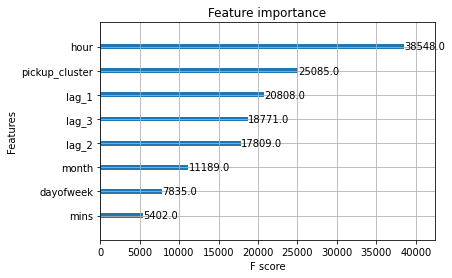

In [28]:
plot_importance(model)

**Observation**
Xgboost performed very well in comparison to random forest - Which is usually the case with time series data  


## Iteration3:
Features: ['pickup_cluster', 'mins', 'hour', 'month', 'quarter', 'dayofweek', 'lag_1', 'lag_2', 'lag_3','rolling_mean']

Include: Both Lag Features and Rolling Window
+ Both of size = 3

lag_{t} = this is simply the request_count of a region {t} mins/hours ago.
rolling_mean: previous 3 days request_count mean

In [29]:
df_test = df_test.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = pd.concat([df_train,df_test])
temp = temp.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = temp.set_index(['ts', 'pickup_cluster', 'mins', 'hour', 'month', 'quarter', 'dayofweek'])

temp['lag_1'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(1)
temp['lag_2'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(2)
temp['lag_3'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(3)
temp['rolling_mean'] = temp.groupby(level=['pickup_cluster'])['request_count'].apply(lambda x: x.rolling(window = 3).mean()).shift(1)

temp = temp.reset_index(drop = False).dropna()
temp = temp[['ts', 'pickup_cluster', 'mins', 'hour', 'month', 'quarter',
       'dayofweek', 'lag_1', 'lag_2', 'lag_3','rolling_mean','request_count']]
train1 = temp[temp.ts.dt.day <=23]
test1 = temp[temp.ts.dt.day >23]

X = train1.iloc[:, 1:-1]
y = train1.iloc[:, -1]
X_test = test1.iloc[:, 1:-1]
y_test = test1.iloc[:, -1]

/var/folders/8c/x24h_w8n7hb83_lmdv9v2zdm0000gn/T/ipykernel_2346/2450149651.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  temp['rolling_mean'] = temp.groupby(level=['pickup_cluster'])['request_count'].apply(lambda x: x.rolling(window = 3).mean()).shift(1)


In [30]:
# from sklearn.ensemble import RandomForestRegressor
# regressor = RandomForestRegressor(n_estimators = 500, random_state=0, n_jobs = -1)
# regressor.fit(X,y)
# print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

# feature_importances = pd.DataFrame(regressor.feature_importances_,
#                                    index = X.columns,
#                                     columns=['importance']).sort_values('importance',ascending=False)
# feature_importances

In [31]:
# dump(regressor, 'random_forest.joblib')

**Observation**
Random Forest overfits - 

### XGBoost with Rolling Window

In [32]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=1500, max_depth=8, objective="reg:squarederror")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set, early_stopping_rounds=20,eval_metric="rmse")
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:9.02170
[1]	validation_0-rmse:8.94121
[2]	validation_0-rmse:8.86156
[3]	validation_0-rmse:8.78279
[4]	validation_0-rmse:8.70496
[5]	validation_0-rmse:8.62804
[6]	validation_0-rmse:8.55210
[7]	validation_0-rmse:8.47678
[8]	validation_0-rmse:8.40242
[9]	validation_0-rmse:8.32882
[10]	validation_0-rmse:8.25601
[11]	validation_0-rmse:8.18402
[12]	validation_0-rmse:8.11315
[13]	validation_0-rmse:8.04290
[14]	validation_0-rmse:7.97334
[15]	validation_0-rmse:7.90444
[16]	validation_0-rmse:7.83646
[17]	validation_0-rmse:7.76910
[18]	validation_0-rmse:7.70245
[19]	validation_0-rmse:7.63658
[20]	validation_0-rmse:7.57160
[21]	validation_0-rmse:7.50707
[22]	validation_0-rmse:7.44349
[23]	validation_0-rmse:7.38089
[24]	validation_0-rmse:7.31863
[25]	validation_0-rmse:7.25704
[26]	validation_0-rmse:7.19633
[27]	validation_0-rmse:7.13622
[28]	validation_0-rmse:7.07672
[29]	validation_0-rmse:7.01810
[30]	validation_0-rmse:6.96000
[31]	validation_0-rmse:6.90260
[32]	validation_0-

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

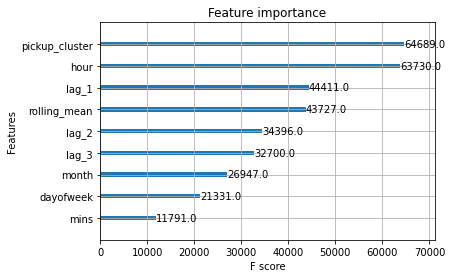

In [33]:
plot_importance(model)

In [34]:
dump(model,'../models/Final_Prediction_model.joblib',compress=3)

['../models/Final_Prediction_model.joblib']

**Observation**

- Adding Lag features and a rolling mean improved the RSME 


* Temporal Dependencies: Time series data often exhibits temporal dependencies where values at the present time may be influenced by past values. By adding lag features, we provided the model with information about previous ride time steps which can help it better capture these temporal patterns.

* Smoothing: Rolling means (or moving averages) are used to smooth out short-term fluctuations and highlight longer-term patterns or trends in the data. This can help the model focus on more general patterns rather than overfitting to noise or short-term anomalies.

* Reduce Noise: By using a rolling mean, we averaged out some of this noise, making the underlying pattern clearer to the model.

* Feature Richness: Enhancing a dataset with more relevant features generally gives models more information to work with, which can lead to improved performance. Lag features and rolling means often encapsulate important historical context of the rides that can be critical for accurate predictions in time series scenarios.

* Capturing Seasonality: There was easonality or periodic component to our data, lag features can help capture it. For example, if you have daily ride data with weekly seasonality, a lag of 7 days can provide the model with information about the same day from the previous week.

# Final Model: Iteration3
+ Good performance with feature addition

# Has Features: `['pickup_cluster','mins','hour','month','dayofweek','quarter', 'lag_1','lag_2','lag_3','rolling_mean']`

* Model Score: 0.93

In [35]:
model = load('../models/Final_Prediction_model.joblib')

In [37]:
model.predict(X_test)

array([0.07730804, 0.06165405, 0.07358546, ..., 8.382334  , 4.8257494 ,
       3.277599  ], dtype=float32)